In [8]:
from src.data_loader import PVDataLoader, PVDataGenerator
from src.data_loader import train_test_split
from gpar import GPARRegressor
import torch
import numpy as np

In [30]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 3
RADIUS = 0.35
COORDS = (55, -1.5)

In [31]:
loader = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

X, y = loader.get_time_series()

x_train, y_train, x_test, y_test = train_test_split(X, y, n_hours=N_HOURS_PRED)

==> Loading data
==> Loaded data in: 0 m : 5 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [45]:
x_obs, y_obs = x_train[::5], y_train[::5]

In [78]:
# create transform that makes output of gpar in 0,1 range in a tuple of (transform, inverse transform)
# (inv normal cdf, normal cdf)
transform_y = (lambda y: torch.distributions.Normal(0, 1).icdf(y), lambda y: torch.distributions.Normal(0, 1).cdf(y))

In [83]:
gpar = GPARRegressor(
    replace=True,
    impute=True,
    per=True,
    scale=1.0,
    linear=False,
    linear_scale=100.0,
    nonlinear=True,
    nonlinear_scale=1.0,
    noise=0.1,
    normalise_y=False,
    #transform_y=transform_y,
    markov=2,
)

In [84]:
gpar.fit(x_obs, y_obs)

Training conditionals (total: 3): 1

 2 3


In [85]:

mean_tr, lower_tr, upper_tr = gpar.predict(
    x_train,
    num_samples=100,
    credible_bounds=True
  )
mean_te, lower_te, upper_te = gpar.predict(
    x_test,
    num_samples=100, 
    credible_bounds=True
  )


Sampling (total: 100): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100
Sampling (total: 100): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


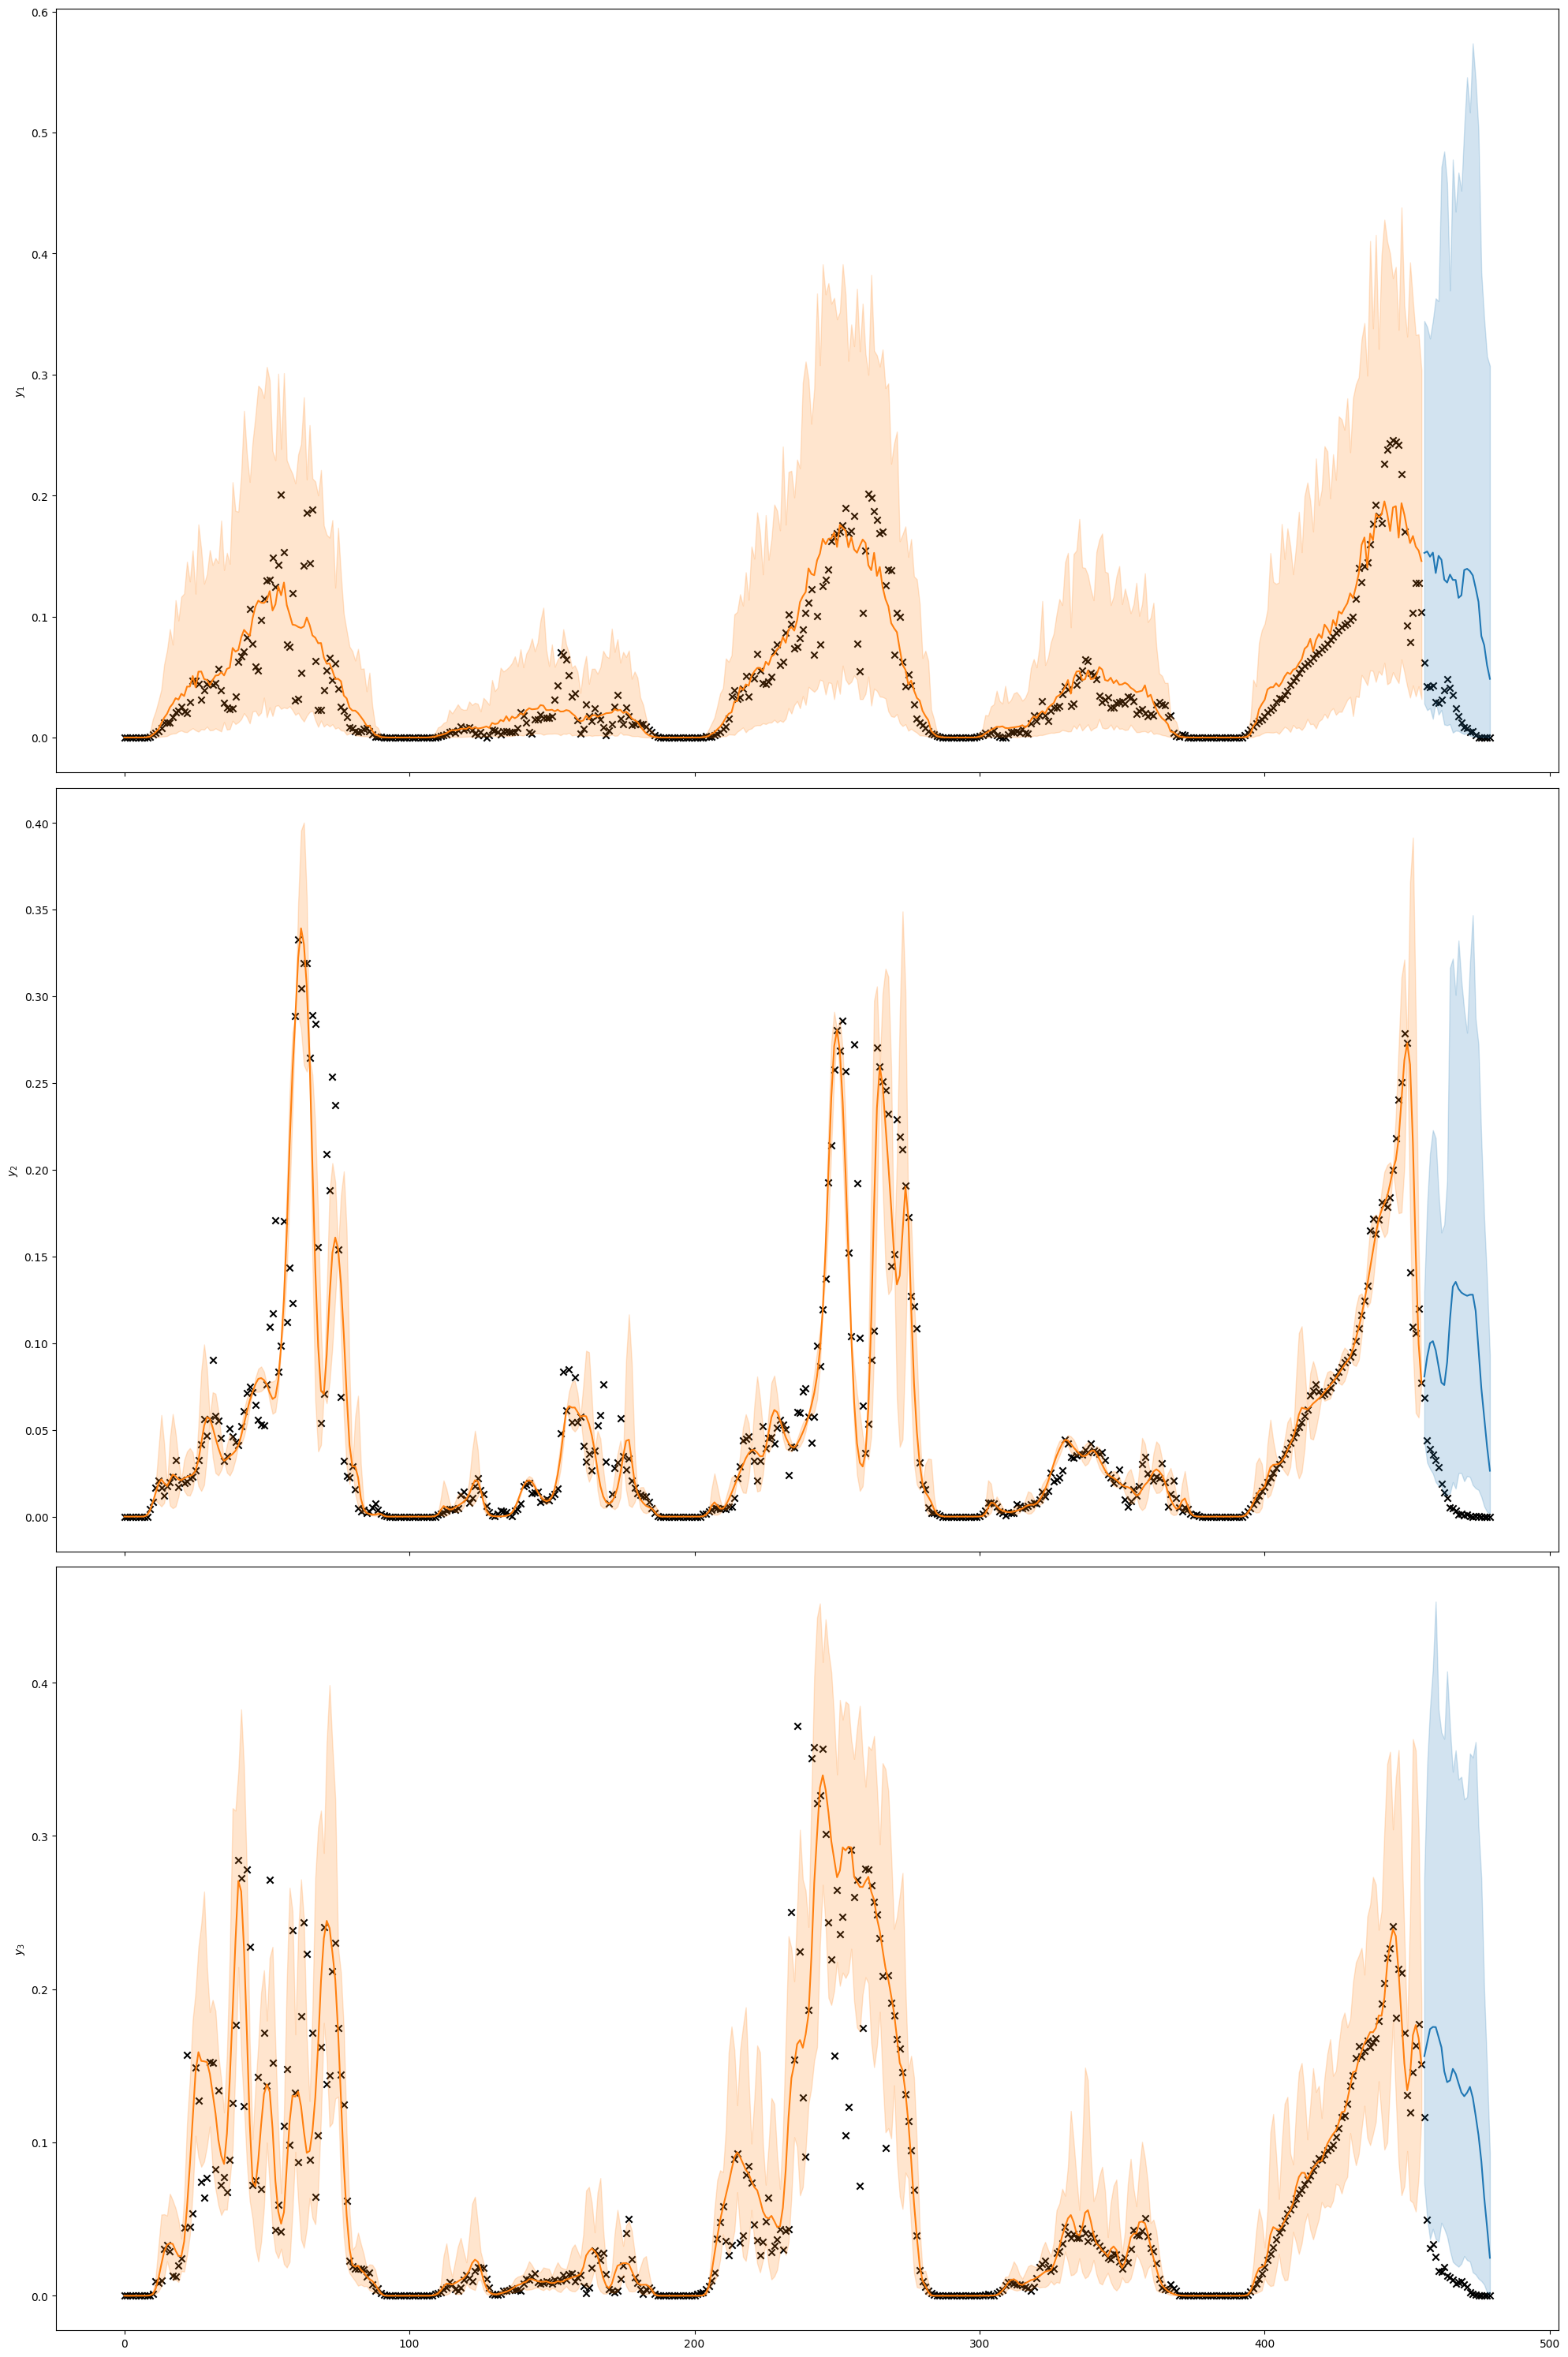

In [82]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(y_train.size(-1), 1,  figsize=(20, 30), sharex=True)

for i in range(y_train.size(-1)):

    # Plot observations.
    ax[i].scatter(X[:,0], y[:, i], color="k", marker="x")

    # Plot GPAR train predictions
    ax[i].plot(x_train[:,0], mean_tr[:, i], color="C1")
    ax[i].fill_between(x_train[:,0], lower_tr[:, i], upper_tr[:, i], color="C1", alpha=0.2)

    # Plot GPAR test predictions.
    ax[i].plot(x_test[:,0], mean_te[:, i], color="C0")
    ax[i].fill_between(x_test[:,0], lower_te[:, i], upper_te[:, i], color="C0", alpha=0.2)

    ax[i].set_ylabel(f"$y_{i + 1}$")
   # ax[i].legend()

plt.tight_layout()